In [43]:
import pandas as pd
import pandas_datareader.data as web
import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import time


In [44]:
#数据开始和结束时间
start=datetime.datetime(2010,1,1)
end=datetime.datetime(2020,1,1)


In [45]:
#实验中提取的股票
#AAPL
#GOOGL
#INTC
#MSFT
#ORCL

In [46]:
web.get_data_yahoo('AAL',start,end).head(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2009-12-31,4.97,4.83,4.92,4.84,5268600.0,4.562870
2010-01-04,4.94,4.66,4.84,4.77,9837300.0,4.496876
2010-01-05,5.37,4.71,4.79,5.31,25212000.0,5.005957
2010-01-06,5.38,5.00,5.19,5.09,16597900.0,4.798555
2010-01-07,5.43,5.05,5.06,5.24,14033400.0,4.939965


In [47]:
#获得股票数据
stock_names = pd.read_csv('D:/DataMining/基于深度学习的金融时序预测/stock_list_name.csv', header=None)
tech = list(stock_names[0][1:10])
df=pd.DataFrame({'AAL':web.get_data_yahoo('AAL',start,end)['Adj Close']})
for i in tech:
    tmp=web.get_data_yahoo(i,start,end)['Adj Close']
    tmp=tmp.rename(i)
    df=pd.merge(df,tmp,how='left',left_index=True,right_index=True)

In [48]:
df.head()

,AAL,AAPL,ADBE,ADI,ADP,ADSK,AKAM,ALXN,AMAT,AMD
Date,,,,,,,,,,
2009-12-31,4.562870,6.503574,36.779999,23.933790,28.693487,25.410000,25.340000,24.410000,11.226706,9.68
2010-01-04,4.496876,6.604801,37.090000,24.001997,28.700174,25.670000,25.920000,24.125000,11.516642,9.70
2010-01-05,5.005957,6.616219,37.700001,23.964100,28.546061,25.280001,26.690001,23.780001,11.428047,9.71
2010-01-06,4.798555,6.510980,37.619999,23.918631,28.479050,25.340000,26.469999,23.840000,11.403889,9.57
2010-01-07,4.939965,6.498945,36.889999,23.729166,28.465643,25.480000,26.480000,23.930000,11.283082,9.47


In [49]:
#数据预处理
#df_pro=(df-df.mean())/df.std()
df_pro=(df.pct_change()).fillna(0)
#df_pro=(df-df.min())/(df.max()-df.min())

In [50]:
df_pro.head()

,AAL,AAPL,ADBE,ADI,ADP,ADSK,AKAM,ALXN,AMAT,AMD
Date,,,,,,,,,,
2009-12-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-01-04,-0.014463,0.015565,0.008429,0.002850,0.000233,0.010232,0.022889,-0.011676,0.025826,0.002066
2010-01-05,0.113208,0.001729,0.016446,-0.001579,-0.005370,-0.015193,0.029707,-0.014300,-0.007693,0.001031
2010-01-06,-0.041431,-0.015906,-0.002122,-0.001897,-0.002347,0.002373,-0.008243,0.002523,-0.002114,-0.014418
2010-01-07,0.029469,-0.001848,-0.019405,-0.007921,-0.000471,0.005525,0.000378,0.003775,-0.010593,-0.010449


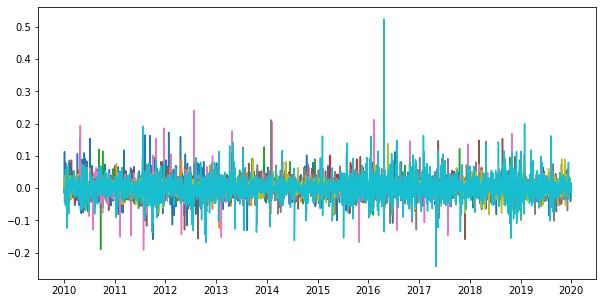

In [51]:
#数据预览
plt.figure(figsize=(10,5))
for i in df_pro.columns:
    plt.plot(df_pro[i])
plt.show()

In [52]:
#参数
time_size=20
input_size=10

In [53]:
#不重叠地切分 -- 250 *20 的数据量
#last=df_pro.shape[0]//time_size*time_size
#input_data=np.split(df_pro.values[:last],last/time_size,axis=0)

In [54]:
#重叠切分
input_data=[]
output_data=[]
seq=df_pro.values
for i in range(len(seq)-time_size-1):
    input_data.append(seq[i:i+time_size])
    output_data.append(seq[i+time_size+1])
input_data=np.array(input_data)
output_data=np.array(output_data)

In [55]:
print(input_data.shape)
print(output_data.shape)

(2496, 20, 10)
(2496, 10)


In [58]:
#实验模型
class ARNNCell(tf.keras.layers.Layer):
    def __init__(self, input_dim, output_dim):
        super(ARNNCell, self).__init__()
        self.input_dim=input_dim
        self.output_dim=output_dim
        self.w1=keras.layers.Dense(input_dim, activation='tanh')
        self.w2=keras.layers.Dense(input_dim, activation='tanh')
        self.w3=keras.layers.Dense(input_dim, activation='tanh')
        self.w4=keras.layers.Dense(output_dim, activation='linear')        
        self.state_size=(self.input_dim,self.input_dim)

    def call(self, inputs, states):
        pre_h=states[0]
        pre_h1=states[1]
        h=self.w2(inputs)+self.w3(pre_h)
        y=self.w1(inputs)*h
        h1=y+pre_h1
        return self.w4(h1), [h,h1]

def model_build_ATT():
    model=keras.Sequential(keras.layers.RNN(ARNNCell(input_dim=40,output_dim=10)))
    return model

In [59]:
#单层LSTM模型
def model_build_LSTM():
    model=keras.Sequential()
    model.add(keras.layers.LSTM(units=20,return_sequences=False))
    model.add(keras.layers.Activation('linear'))
    model.add(keras.layers.Dense(units=5))
    return model

In [60]:
##损失函数
def loss_(y_pred,y_true):
    return tf.reduce_mean(tf.square(y_pred-y_true))+tf.exp(-1*y_pred*y_true)
    #return tf.reduce_mean(tf.square(y_pred-y_true))+100*tf.exp(-(y_pred*y_true)/tf.abs(y_pred*y_true))
    #return tf.reduce_mean(tf.square(y_pred-y_true))+tf.exp(-10000*(y_pred*y_true))

In [61]:
#data to [train,test]
#数据切分成训练数据和测试数据
train_size=int(input_data.shape[0]*0.8)
train_x=input_data[:train_size]
test_x=input_data[train_size+1:]
train_y=output_data[:train_size]
test_y=output_data[train_size+1:]

In [62]:
#模型训练函数
def train_model(train_x,train_y,test_x,test_y):
    model=model_build_ATT()
    #model=model_build_LSTM()
    model_name='att'

    #model.compile(loss='mse',optimizer='adam')
    model.compile(loss='mse',optimizer='adam')
    history=model.fit(train_x,train_y,batch_size=4,epochs=200,verbose=1,shuffle=False)
    model.summary()
    
    loss = history.history['loss']
    predict=model.predict(test_x)
    return predict,loss,model_name

In [63]:
print(train_x.shape,test_x.shape,train_y.shape,test_y.shape)

(1996, 20, 10) (499, 20, 10) (1996, 10) (499, 10)


In [69]:
#训练模型
time_start = time.time()
predict,loss,model=train_model(train_x, train_y, test_x, test_y)
time_end = time.time()
print("The training process takes: " + str(time_end - time_start) + 's')

Train on 1996 samples
Epoch 1/200
1996/1996 [==============================] - 3s 2ms/sample - loss: 5.0976e-04
Epoch 2/200
1996/1996 [==============================] - 2s 1ms/sample - loss: 4.9985e-04
Epoch 3/200
1996/1996 [==============================] - 3s 1ms/sample - loss: 4.9775e-04
Epoch 4/200
1996/1996 [==============================] - 3s 1ms/sample - loss: 4.9542e-04
Epoch 5/200
1996/1996 [==============================] - 2s 1ms/sample - loss: 4.9318e-04
Epoch 6/200
1996/1996 [==============================] - 3s 1ms/sample - loss: 4.9100e-04
Epoch 7/200
1996/1996 [==============================] - 3s 1ms/sample - loss: 4.8913e-04
Epoch 8/200
1996/1996 [==============================] - 3s 1ms/sample - loss: 4.8697e-04
Epoch 9/200
1996/1996 [==============================] - 3s 1ms/sample - loss: 4.8521e-04
Epoch 10/200
1996/1996 [==============================] - 3s 1ms/sample - loss: 4.8380e-04
Epoch 11/200
1996/1996 [==============================] - 3s 1ms/sample - los

1996/1996 [==============================] - 2s 1ms/sample - loss: 4.3882e-04
Epoch 91/200
1996/1996 [==============================] - 2s 1ms/sample - loss: 4.4143e-04
Epoch 92/200
1996/1996 [==============================] - 2s 1ms/sample - loss: 4.3780e-04
Epoch 93/200
1996/1996 [==============================] - 2s 1ms/sample - loss: 4.3995e-04
Epoch 94/200
1996/1996 [==============================] - 2s 1ms/sample - loss: 4.3819e-04
Epoch 95/200
1996/1996 [==============================] - 2s 1ms/sample - loss: 4.3884e-04
Epoch 96/200
1996/1996 [==============================] - 2s 1ms/sample - loss: 4.3660e-04
Epoch 97/200
1996/1996 [==============================] - 2s 1ms/sample - loss: 4.3823e-04
Epoch 98/200
1996/1996 [==============================] - 3s 1ms/sample - loss: 4.3620e-04
Epoch 99/200
1996/1996 [==============================] - 2s 1ms/sample - loss: 4.3786e-04
Epoch 100/200
1996/1996 [==============================] - 2s 1ms/sample - loss: 4.3581e-04
Epoch 101/2

1996/1996 [==============================] - 2s 1ms/sample - loss: 4.3178e-04
Epoch 179/200
1996/1996 [==============================] - 2s 1ms/sample - loss: 4.3323e-04
Epoch 180/200
1996/1996 [==============================] - 3s 1ms/sample - loss: 4.2839e-04
Epoch 181/200
1996/1996 [==============================] - 2s 1ms/sample - loss: 4.3093e-04
Epoch 182/200
1996/1996 [==============================] - 2s 1ms/sample - loss: 4.3115e-04
Epoch 183/200
1996/1996 [==============================] - 2s 1ms/sample - loss: 4.3261e-04
Epoch 184/200
1996/1996 [==============================] - 2s 1ms/sample - loss: 4.2753e-04
Epoch 185/200
1996/1996 [==============================] - 2s 1ms/sample - loss: 4.3024e-04
Epoch 186/200
1996/1996 [==============================] - 2s 1ms/sample - loss: 4.2916e-04
Epoch 187/200
1996/1996 [==============================] - 2s 1ms/sample - loss: 4.3102e-04
Epoch 188/200
1996/1996 [==============================] - 2s 1ms/sample - loss: 4.2612e-04
Ep

In [71]:
predict.shape

(499, 10)

499


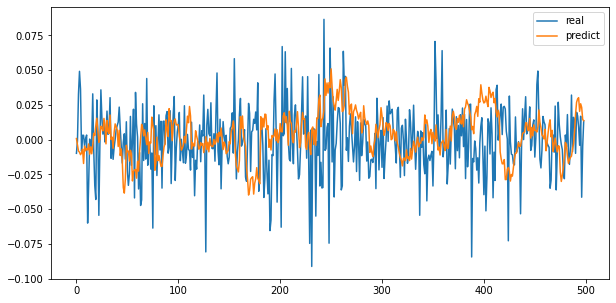

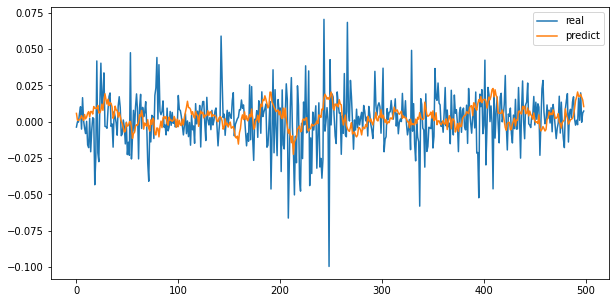

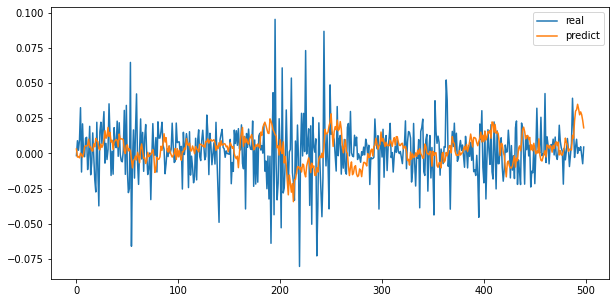

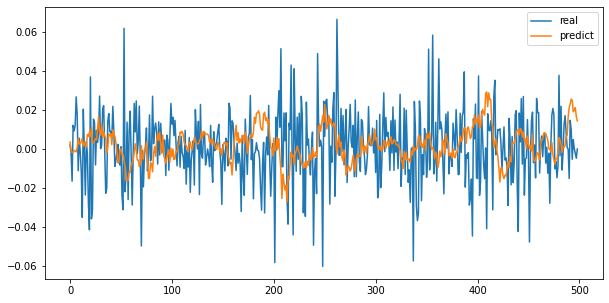

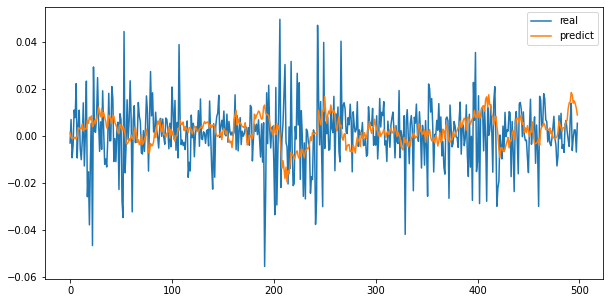

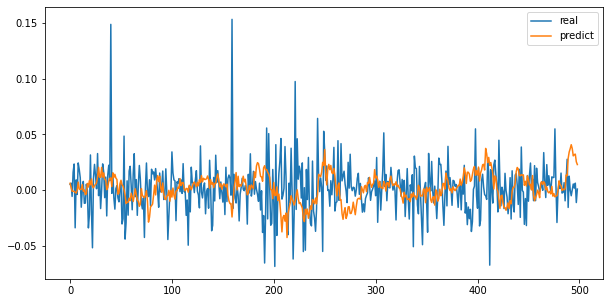

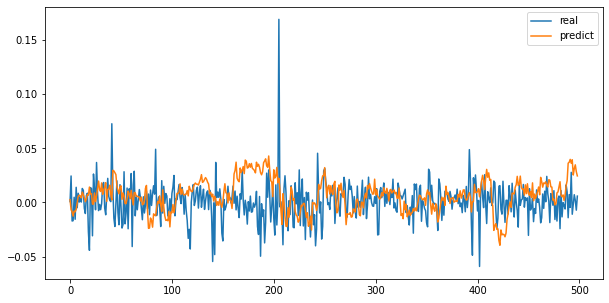

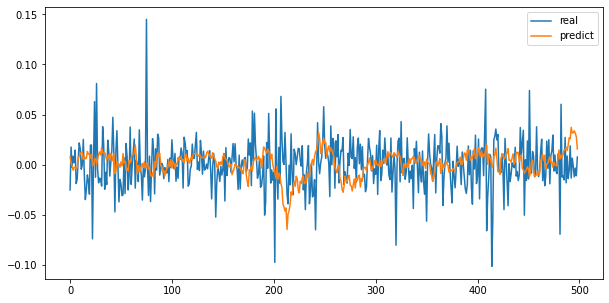

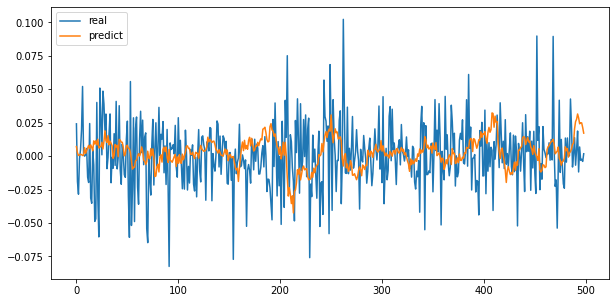

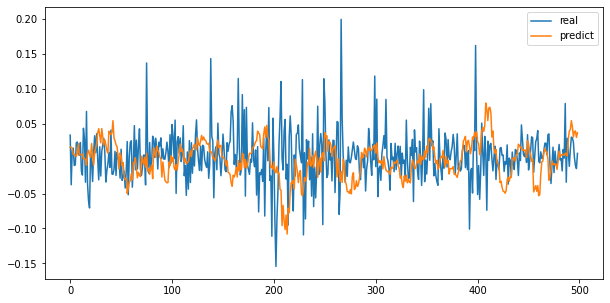

In [73]:
#真实和预测结果
test_y_list=np.split(test_y,10,axis=1)
predict_list=np.split(predict,10,axis=1)
print(len(predict_list[0]))
for i in range(10):
    plt.figure(figsize=(10,5))
    plt.plot(test_y_list[i],label='real')
    plt.plot(predict_list[i],label='predict')
    plt.legend()
    plt.show()

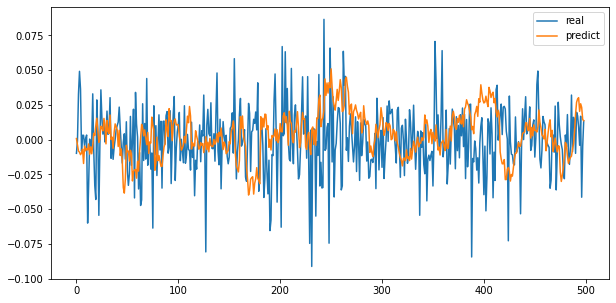

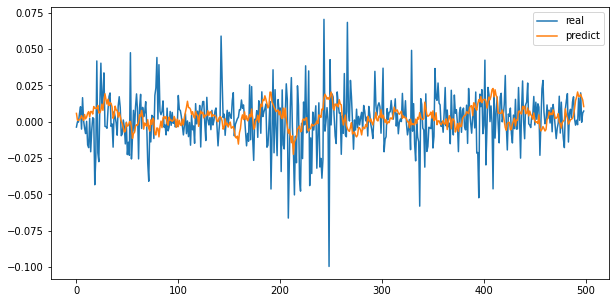

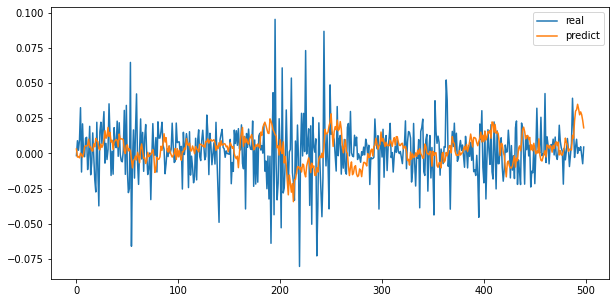

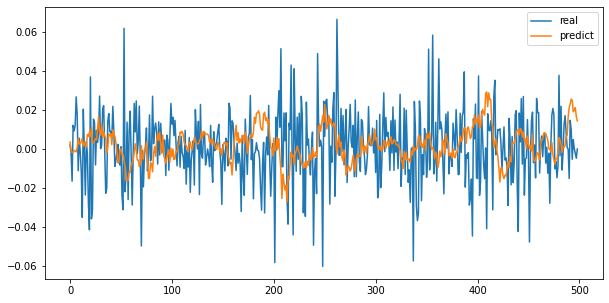

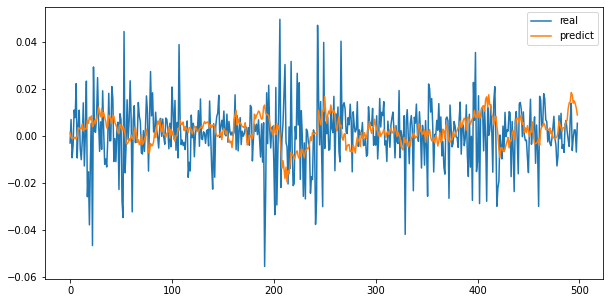

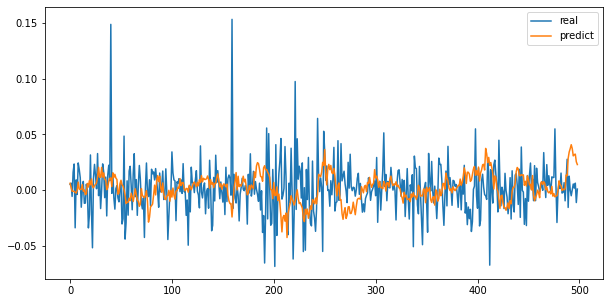

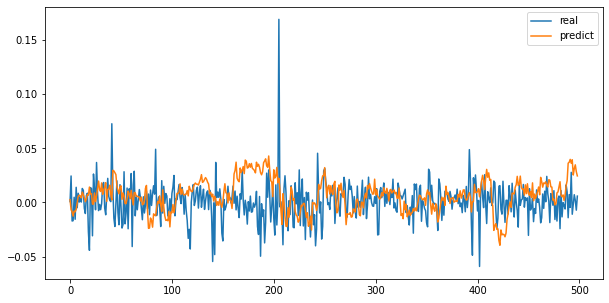

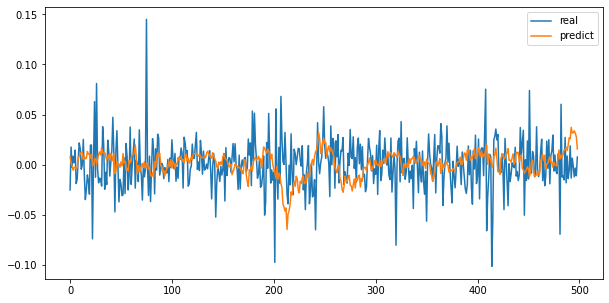

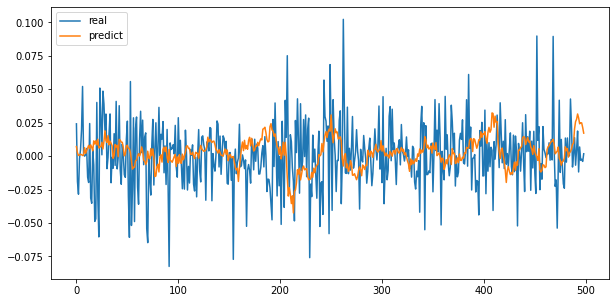

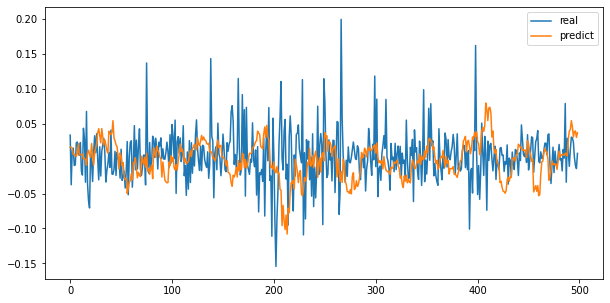

In [75]:
test_y_list=np.split(test_y,10,axis=1)
predict_list=np.split(predict,10,axis=1)
for i in range(10):
    plt.figure(figsize=(10,5))
    plt.plot(test_y_list[i],label='real')
    plt.plot(predict_list[i],label='predict')
    plt.legend()
    plt.show()

In [76]:
print('rmse:{}'.format(np.sqrt(np.mean(np.square(predict-test_y)))))

rmse:0.026158110152529192


In [77]:
#选取增量最大的股票进行投递  数据为价格
def stragety():
    #init
    cap_str=100000
    cap_cg=[cap_str]
    for i in range(len(predict)-1):
        cur,ind=0,-1
        for j in range(input_size):
            if(predict[i+1][j]/predict[i][j]-1>cur):
                cur=predict[i+1][j]/predict[i][j]-1
                ind=j
        if cur>0:
            cap_str=cap_str*test_y[i+1][ind]/test_y[i][ind]
        cap_cg.append(cap_str)
    return cap_cg

def origin():
    cap_ori=100000
    cap_cg=[cap_ori]
    for i in range(len(predict)-1):
        cap_ori=cap_ori*test_y[i+1][0]/test_y[i][0]
        cap_cg.append(cap_ori)
    return cap_cg

In [78]:
#选取增量最大的股票进行投递  数据为增长率
def stragety_rate():
    #init
    cap_str=100000
    cap_cg=[cap_str]
    for i in range(len(predict)-1):
        cur,ind=0,-1
        for j in range(input_size):
            if(predict[i+1][j]>cur):
                cur=predict[i+1][j]
                ind=j
        if cur>0:
            cap_str=cap_str*(1+test_y[i+1][ind])
        cap_cg.append(cap_str)
    return cap_cg

def origin_rate():
    cap_ori=100000
    cap_cg=[cap_ori]
    for i in range(len(predict)-1):
        cap_ori=cap_ori*(1+test_y[i+1][0])
        cap_cg.append(cap_ori)
    return cap_cg

C:\Users\jingw\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
C:\Users\jingw\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


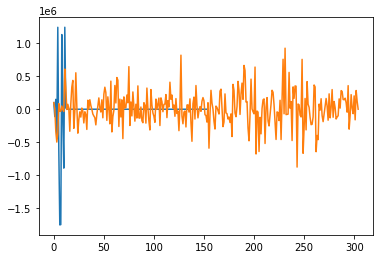

In [79]:
#策略结果  数据为价格
cap_s=stragety()
cap_o=origin()
plt.plot(cap_s)
plt.plot(cap_o)
plt.show()

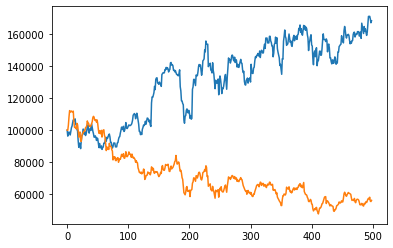

In [82]:
#策略结果 数据为增长率
cap_s=stragety_rate()
cap_o=origin_rate()
plt.plot(cap_s)
plt.plot(cap_o)
plt.show()

In [ ]:
def log():